# ・ライブラリのインポート

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

import itertools
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# ・データの読み込み

In [15]:
train = pd.read_csv('/Users/markun/SIGNATE/train.csv')
test = pd.read_csv('/Users/markun/SIGNATE/test.csv')

In [16]:
test = test.drop(['Pregnancies','BloodPressure','SkinThickness','Insulin'], axis = 1)
test 

,index,Glucose,BMI,DiabetesPedigreeFunction,Age
0,398,126,40.096264,0.822517,21
1,3833,88,39.810590,0.204331,22
2,4836,114,33.198760,0.521011,21
3,4572,146,26.890259,0.504950,38
4,636,123,40.270088,0.800513,28
...,...,...,...,...,...
1995,3138,150,39.385785,0.175051,26
1996,191,153,38.614204,0.509367,28
1997,3294,106,51.678147,0.728404,29
1998,3073,101,40.271989,0.316558,26


In [17]:
train

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,200,9,125,74,0,0,28.536910,0.444902,45,1
1,3832,4,109,80,0,0,28.047673,0.238243,22,0
2,4927,4,88,78,39,0,52.371341,0.279471,26,0
3,4088,9,125,74,0,0,40.062688,0.203922,45,0
4,3644,5,107,78,44,284,52.935068,0.284959,45,1
...,...,...,...,...,...,...,...,...,...,...
2995,4931,4,88,74,17,0,33.848723,0.171073,23,0
2996,3264,0,144,88,0,0,26.846832,0.259957,21,1
2997,1653,6,117,96,36,0,28.101646,0.716126,22,1
2998,2607,2,113,74,0,0,33.079021,0.266179,38,1


# ・目的変数を除外

In [18]:
train_x = train.drop(['Outcome'], axis = 1)
train_x 

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,200,9,125,74,0,0,28.536910,0.444902,45
1,3832,4,109,80,0,0,28.047673,0.238243,22
2,4927,4,88,78,39,0,52.371341,0.279471,26
3,4088,9,125,74,0,0,40.062688,0.203922,45
4,3644,5,107,78,44,284,52.935068,0.284959,45
...,...,...,...,...,...,...,...,...,...
2995,4931,4,88,74,17,0,33.848723,0.171073,23
2996,3264,0,144,88,0,0,26.846832,0.259957,21
2997,1653,6,117,96,36,0,28.101646,0.716126,22
2998,2607,2,113,74,0,0,33.079021,0.266179,38


# ・目的変数

In [19]:
train_y = train['Outcome']
train_y

0       1
1       0
2       0
3       0
4       1
       ..
2995    0
2996    1
2997    1
2998    1
2999    0
Name: Outcome, Length: 3000, dtype: int64

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42),
                        threshold = 'median')

In [21]:
select.fit(train_x, train_y)
train_x_l1 = select.transform(train_x)
print('train_x.shape:{}'.format(train_x.shape))
print('train_x_l1.shape:{}'.format(train_x_l1.shape))

train_x.shape:(3000, 9)
train_x_l1.shape:(3000, 5)


[ True False  True False False False  True  True  True]


Text(0.5, 0, 'Sample index')

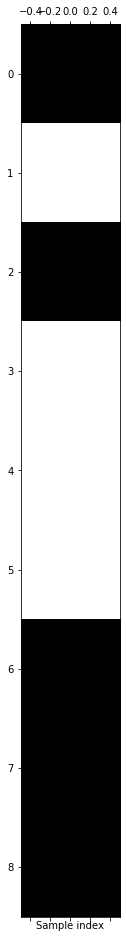

In [22]:
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(-1,1), cmap = 'gray_r')
plt.xlabel('Sample index')

In [23]:
train_x_2 = train.drop(['Pregnancies','BloodPressure','SkinThickness','Insulin','Outcome'], axis = 1)
train_x_2

,index,Glucose,BMI,DiabetesPedigreeFunction,Age
0,200,125,28.536910,0.444902,45
1,3832,109,28.047673,0.238243,22
2,4927,88,52.371341,0.279471,26
3,4088,125,40.062688,0.203922,45
4,3644,107,52.935068,0.284959,45
...,...,...,...,...,...
2995,4931,88,33.848723,0.171073,23
2996,3264,144,26.846832,0.259957,21
2997,1653,117,28.101646,0.716126,22
2998,2607,113,33.079021,0.266179,38


# ・学習及び検証

In [65]:
xgb_params = {
    'objective':'binary:logistic',
    'max_depth': 6, 
    'eta': 0.02,
    'eval_metric':'logloss',
    'colsample_bytree':0.8,
    'subsample':0.8,
    'gamma':0,
    'lambda':1,
    'alpha':0,
    'min_child_weight':1.0,
}

    #model = XGBClassifier(n_estimators=60, random_state=71, max_depth = 4)
model = XGBClassifier(n_estimators=200, random_state=2021, max_depth = 5, eta = 0.06, min_child_weight = 1,colsample_bytree = 0.7,subsample = 0.7)
scores = cross_val_score(model, train_x_2, train_y, cv = 10)
print('cross-validation scores:{}'.format(scores))

cross-validation scores:[0.80333333 0.80333333 0.79666667 0.79       0.81333333 0.79333333
 0.81333333 0.77       0.8        0.80333333]


In [66]:
print('average cross-validation score:{:.2f}'.format(scores.mean()))

average cross-validation score:0.80


In [67]:
model.fit(train_x_2, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.06, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0599999987, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=2021, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

#  ・テストデータに対する予測

In [68]:
prediction = model.predict(test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

# ・提出用ファイルの作成

In [69]:
submission_D3 = pd.DataFrame({
    'index':test['index'],
    'Outcome':prediction, 
})
submission_D3.to_csv('/Users/markun/SIGNATE/submission_D3.csv', header = False, index = False )

In [70]:
submission_D2.head(30)

,index,Outcome
0,398,0
1,3833,0
2,4836,0
3,4572,0
4,636,0
5,2545,0
6,1161,0
7,2230,0
8,148,0
9,2530,0
